
E2 File: GISS-E2-1-G
historical r1i1p1f2 gn v20190903 (195101-200012)
(Daily, Mean)

E3 File: GISS-E3-G
historical r1i1p1f1 gn v20190903 (195101-200012)
(Daily, Mean)
╒══════════════════════════╤═══════════╤═══════════╤══════════════════════════╤═════════════════════╕
│ Statistic (for tasmax)   │   GISS-E2 │   GISS-E3 │   Percent Difference (%) │ Test (within 10%)   │
╞══════════════════════════╪═══════════╪═══════════╪══════════════════════════╪═════════════════════╡
│ Mean                     │   279.467 │   279.323 │                    0.052 │ PASS                │
├──────────────────────────┼───────────┼───────────┼──────────────────────────┼─────────────────────┤
│ Median                   │   284.431 │   284.38  │                    0.018 │ PASS                │
├──────────────────────────┼───────────┼───────────┼──────────────────────────┼─────────────────────┤
│ Minimum                  │   179.312 │   186.345 │                    3.774 │ PASS                │
├───────────────

KL Divergence: 1.69e+07

E2 File: GISS-E2-1-G
historical r1i1p1f2 gn v20190903 (200001-201412)
(Daily, Mean)

E3 File: GISS-E3-G
historical r1i1p1f1 gr v20220727 (200001-201412)
(Daily, Mean)
╒══════════════════════════╤═══════════╤═══════════╤══════════════════════════╤═════════════════════╕
│ Statistic (for tasmin)   │   GISS-E2 │   GISS-E3 │   Percent Difference (%) │ Test (within 10%)   │
╞══════════════════════════╪═══════════╪═══════════╪══════════════════════════╪═════════════════════╡
│ Mean                     │   275.161 │   276.393 │                    0.446 │ PASS                │
├──────────────────────────┼───────────┼───────────┼──────────────────────────┼─────────────────────┤
│ Median                   │   280.111 │   280.556 │                    0.159 │ PASS                │
├──────────────────────────┼───────────┼───────────┼──────────────────────────┼─────────────────────┤
│ Minimum                  │   175.635 │   205.918 │                   14.706 │ FAIL          

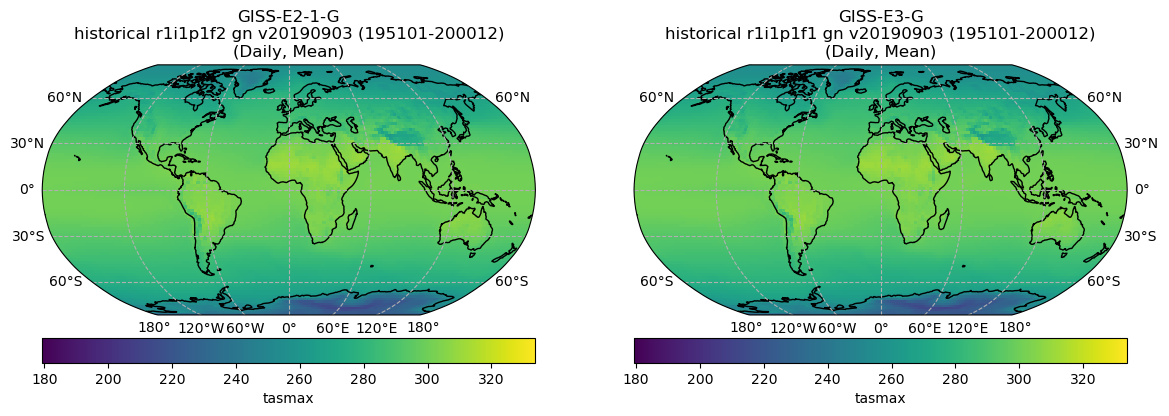

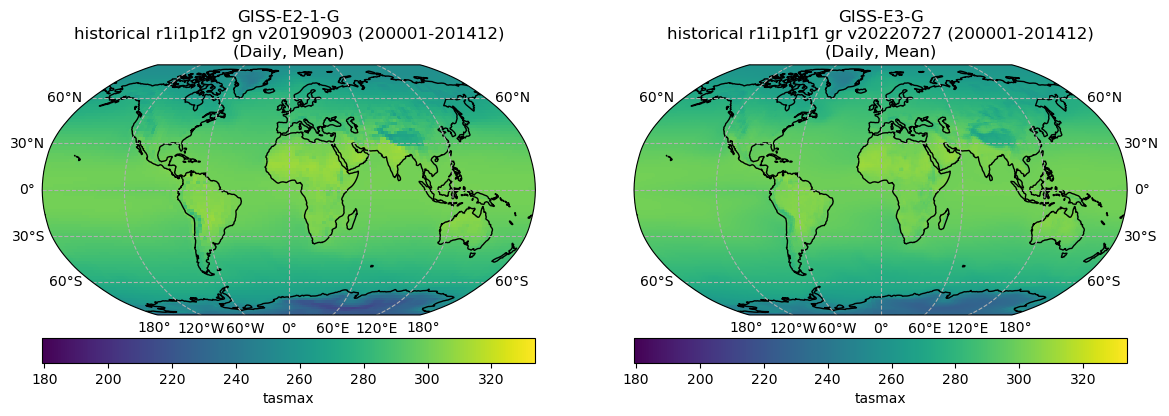

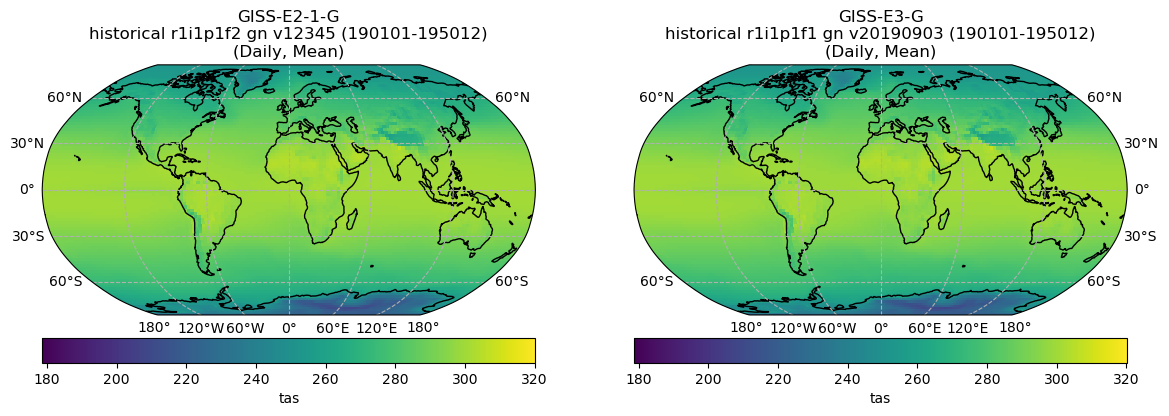

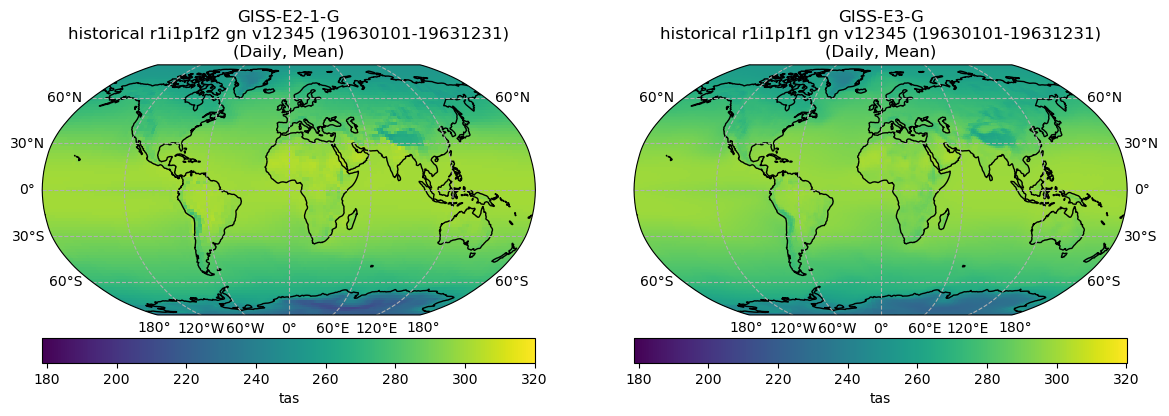

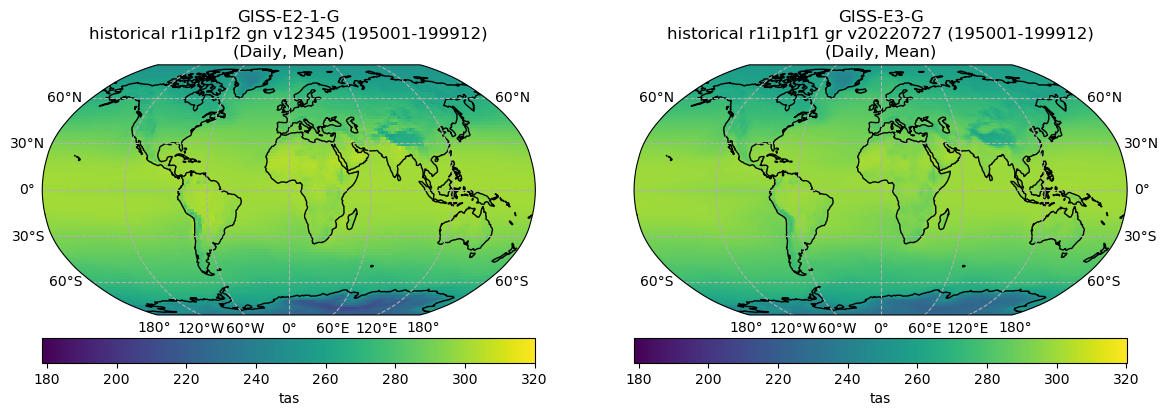

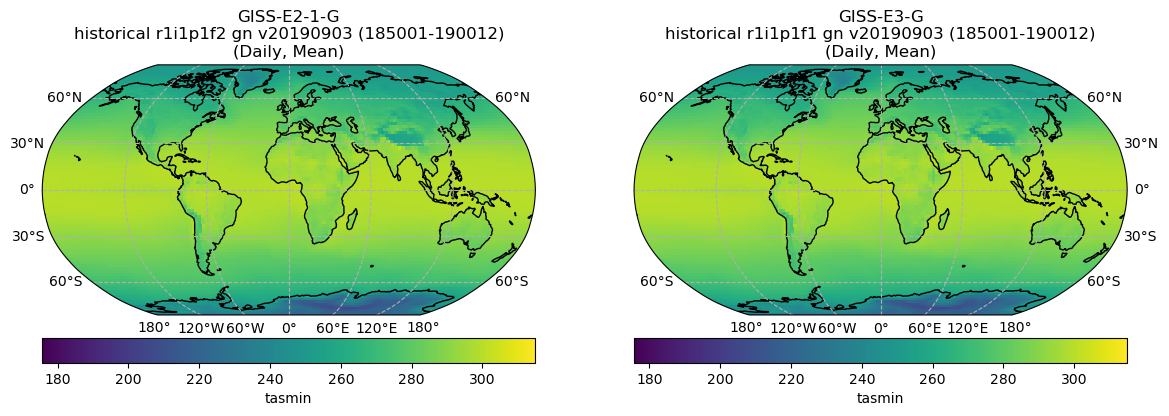

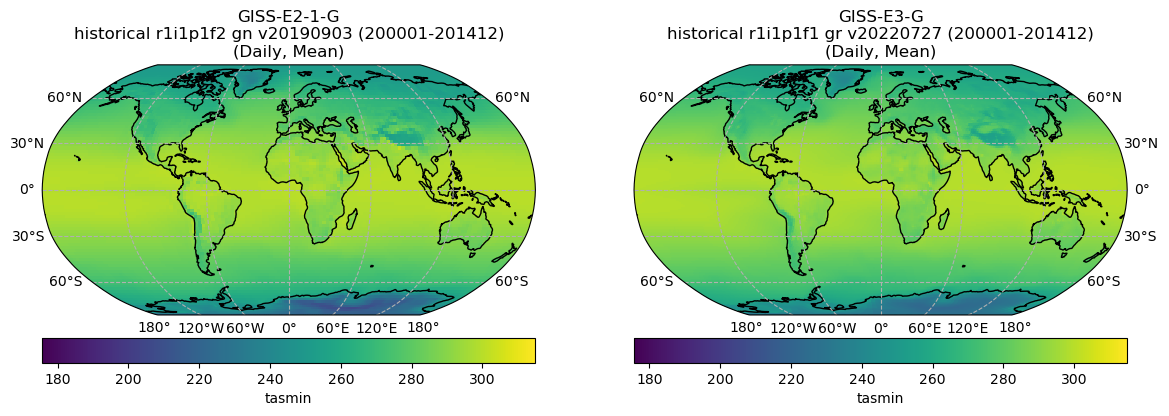

In [66]:
import glob
import os
import time
import sys
import argparse
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs

from matplotlib import pyplot as plt
from cmor_plot.cmor_plot.cptools import Tools as cpt

# Time entire process
start = time.time()

# Collect command line arguments
options = cpt.readOptions(sys.argv[1:])
runE2 = options.EXrun
runE3 = options.E3run
figure_name = options.figure_name
hist_option = options.histogram
variable = options.variable

# Change directory and set paths for looping
outdir = os.getcwd()
os.chdir(outdir)
allvarsE2 = runE2 + "*/*/*/*"
allvarsE3 = runE3 + "*/*/*/*"

# Set central longitude for plotting
central_lon = 0

# Loop through the E3 directory 
for direc3 in glob.glob(allvarsE3):
        
    # Call 'get_sample' for E3, save filename and open dataset
    fileE3 = cpt.get_sample(direc3, outdir)
    
    if ('/fx/' in fileE3) | ('/fy/' in fileE3) | ('/Ofx/' in fileE3) | ('/Ofy/' in fileE3):
        None
    else:
        dsE3 = xr.open_dataset(fileE3, decode_times=False)
        
        # Get relevant varname & frequency
        freq = direc3.split("/")[-4]
        varname = direc3.split("/")[-3]

        # Compare variable to file name to command line input variable
        if (variable is None) or (varname in variable):

            # Collect info from directory structure
            gride3 = direc3.split("/")[-2]
            modelv2 = runE2.split('CMIP6')[1].split('/')[3]
            modelv3 = direc3.split("/")[-7]
            
            # Try to find the same var/freq in E2
            # start here-- basically try to get the same file using the freq and varname defined earlier. if exception, plot no data
            e3version = direc3.split("/")[-1]
            e2path_short = runE2 + direc3.split(e3version)[0].split(runE3)[1]
            e2path_full = e2path_short + "*"
            direc2 = glob.glob(e2path_full)
            if len(direc2) > 0:
                direc2 = direc2[0]
                os.chdir(direc2) # if this fails, there was no path found (aka no matching data)
                fileE2 = cpt.get_sample(direc2, outdir)

                # Create e2 dataset
                dsE2 = xr.open_dataset(fileE2, decode_times=False)

                # Verify that E2 variable exists, and carry on
                varexist = 1
                
            else:
                # Check if there is a native grid E2 match to E3 regridded
                if gride3 == "gr":
                    e2path_full_native = e2path_full.replace("/gr/", "/gn/")
                    direc2 = glob.glob(e2path_full_native)
                    if len(direc2) > 0:
                        direc2 = direc2[0]
                        os.chdir(direc2) # if this fails, there was no path found (aka no matching data)
                        fileE2 = cpt.get_sample(direc2, outdir)

                        # Create E2 dataset
                        dsE2 = xr.open_dataset(fileE2)

                        # Verify that E2 variable exists, and carry on
                        varexist = 1
                else:   
                    print("No E2 match found for " + fileE3.split('/')[-1] + ", skipping...")
                    dsE2 = None
                    varexist = 0
                    
            # Check for num dimensions
            dsE3 = cpt.check_dim(dsE3, varname)
            if varexist == 1:
                dsE2 = cpt.check_dim(dsE2, varname)
            
            # Title for primary plot
            years = fileE3.split('_')[-1].split('.')[0]
            m3title = direc3.split("/")[-7] + "\n" + direc3.split("/")[-6] + " " + direc3.split("/")[-5] + " " \
                    + direc3.split("/")[-2] + " " + direc3.split("/")[-1] + " " + "(" + years + ")" + '\n(Daily, Mean)'
            if varexist == 1:
                m2title = direc2.split("/")[-7] + "\n" + direc2.split("/")[-6] + " " + direc2.split("/")[-5] + " " \
                        + direc2.split("/")[-2] + " " + direc2.split("/")[-1] + " " + "(" + years + ")" + '\n(Daily, Mean)'
            
            # Get cbar labels
            try:
                labele3 = 'Mean' + dsE3[varname].attrs["units"]
            except:
                labele3 = 'Mean' + varname
            try:
                labele2 = 'Mean' + dsE2[varname].attrs["units"]
            except:
                labele2 = 'Mean' + varname

            end = time.time()

            # Calculate bounds for colorbars (should be same for both plots)
            maxval_E2 = dsE2[varname].max().values
            maxval_E3 = dsE3[varname].max().values
            minval_E2 = dsE2[varname].min().values
            minval_E3 = dsE3[varname].min().values
            cbar_upper = max(maxval_E2, maxval_E3)
            cbar_lower = min(minval_E2, minval_E3)

            # E2 plot (left)
            if varexist == 1:
                fig = plt.figure(figsize=(14,5))
                ax1 = plt.subplot(1, 2, 1, projection=ccrs.Robinson(central_lon))
                gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--')
                gl1.top_labels = gl1.right_labels = False
                dsE2[varname].mean('time').plot(transform=ccrs.PlateCarree(),
                                cbar_kwargs={'orientation':'horizontal','pad': 0.06},
                                vmax=cbar_upper,
                                vmin=cbar_lower)
                ax1.coastlines()
                plt.title(m2title)

            else:
                fig = plt.figure()
                ax1 = plt.subplot(1, 2, 1, projection=ccrs.Robinson(central_lon))
                ax1.text(0.25, 0.5, 'NO DATA', fontsize=40)
                plt.title(m2title)
                plt.xticks([])
                plt.yticks([])

            # E3 plot (right)
            ax2 = plt.subplot(1, 2, 2, projection=ccrs.Robinson(central_lon))
            gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--')
            gl2.top_labels = gl2.left_labels = False
            dsE3[varname].mean('time').plot(transform=ccrs.PlateCarree(),
                            cbar_kwargs={'orientation':'horizontal','pad': 0.06},
                            vmax=cbar_upper,
                            vmin=cbar_lower)
            ax2.coastlines()
            plt.title(m3title)
            plt.xlabel('')
            plt.ylabel('')
            plt.xticks([])
            plt.yticks([])

            # Calculate and print formatted statistics table
            formatted_df = cpt.stats_df(dsE2, dsE3, 10)
            print(f'\nE2 File: {m2title}\n\nE3 File: {m3title}')
            print(formatted_df)

            # Print KL divergence between E2 and E3
            E2_vals = list(dsE2.data_vars.items())[-1][1].values.flatten()
            E3_vals = list(dsE3.data_vars.items())[-1][1].values.flatten()
            print(f'KL Divergence: {cpt.KL_divergence(E2_vals, E3_vals)}')

            # Create histogram if -hist option used
            if hist_option is True:

                # Histogram title
                hist_title = direc2.split("/")[-7] + ' ' + direc2.split("/")[-6] + " " + direc2.split("/")[-5] + " " \
                            + direc2.split("/")[-2] + " " + direc2.split("/")[-1] + " " + "(" + years + ")\n" \
                            + direc3.split("/")[-7] + ' ' + direc3.split("/")[-6] + " " + direc3.split("/")[-5] + " " \
                            + direc3.split("/")[-2] + " " + direc3.split("/")[-1] + " " + "(" + years + ")" \
                            + '\n(Daily, Mean)'

                # Plot histogram of E2 and E3 data
                cpt.histogram(E2_vals, E2_vals, hist_title, varname)

            # Default is to not plot histogram
            else:
                pass

        # Don't analyze files for variables not included in query
        else:
            pass

# Name file, save all plots
cpt.save_image(figure_name)

# Calculate overall time
end = time.time()
duration = round(end - start, 3)
print(f'\nTotal time: {duration} seconds')